# Homework 3 - Text Classification
Author: Kandarp Khandwala - kkhandw1

Text Mining

* Data: books.csv contains 2,000 Amazon book reviews. Each row represents a review for one book. The data set contains two columns: the first column (contained in quotes) is the review text. The second column is a binary label indicating if the review is positive or negative.

* Tasks: Described below


In [1]:
import string

# Import pandas to read in data
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## Text classification
We are going to look at some Amazon reviews and classify them into positive or negative.

### Data
The file `books.csv` contains 2,000 Amazon book reviews. The data set contains two features: the first column (contained in quotes) is the review text. The second column is a binary label indicating if the review is positive or negative.

Let's take a quick look at the file.

In [2]:
!head -3 books.csv

review_text,positive
"THis book was horrible.  If it was possible to rate it lower than one star i would have.  I am an avid reader and picked this book up after my mom had gotten it from a friend.  I read half of it, suffering from a headache the entire time, and then got to the part about the relationship the 13 year old boy had with a 33 year old man and i lit this book on fire.  One less copy in the world...don't waste your money.I wish i had the time spent reading this book back so i could use it for better purposes.  THis book wasted my life",0
"I like to use the Amazon reviews when purchasing books, especially alert for dissenting perceptions about higly rated items, which usually disuades me from a selection.  So I offer this review that seriously questions the popularity of this work - I found it smug, self-serving and self-indulgent, written by a person with little or no empathy, especially for the people he castigates. For example, his portrayal of the family therapist seems

Let's read the data into a pandas data frame. You'll notice two new attributed in `pd.read_csv()` that we've never seen before. The first, `quotechar` is tell us what is being used to "encapsulate" the text fields. Since our review text is surrounding by double quotes, we let pandas know. We use a `\` since the quote is also used to surround the quote. This backslash is known as an escape character. We also let pandas now this.

In [3]:
data = pd.read_csv("books.csv", quotechar="\"", escapechar="\\")

In [4]:
data.head()

,review_text,positive
0,THis book was horrible. If it was possible to...,0
1,I like to use the Amazon reviews when purchasi...,0
2,THis book was horrible. If it was possible to...,0
3,"I'm not sure who's writing these reviews, but ...",0
4,I picked up the first book in this series (The...,0


### Task 1: Preprocessing the text (25 points)

Change text to lower case and remove stop words, then transform the row text collection into a matrix of token counts.

Hint: sklearn's function CountVectorizer has built-in options for these operations. Refer to http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html for more information.

In [5]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [6]:
data['review_text'].head(5).apply(text_process)

0    [book, horrible, possible, rate, lower, one, s...
1    [like, use, Amazon, reviews, purchasing, books...
2    [book, horrible, possible, rate, lower, one, s...
3    [Im, sure, whos, writing, reviews, read, repit...
4    [picked, first, book, series, Eyre, Affair, ba...
Name: review_text, dtype: object

In [7]:
tokenizer = CountVectorizer(lowercase=True, analyzer=text_process)
reviews = tokenizer.fit_transform(data['review_text'])
reviews.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
print('Sample Feature names: ', tokenizer.get_feature_names()[-10:])
print('Shape of Sparse Matrix: ', reviews.shape)
print('Amount of Non-Zero occurences: ', reviews.nnz)
print('Sparsity: %.2f%%' % (100.0 * reviews.nnz / (reviews.shape[0] * reviews.shape[1])))

Sample Feature names:  ['zillion', 'zing', 'zinger', 'zip', 'zipped', 'zit', 'zombie', 'zombies', 'zone', 'zooming']
Shape of Sparse Matrix:  (2000, 30903)
Amount of Non-Zero occurences:  147810
Sparsity: 0.24%


### Task 2: Build a logistic regression model using token counts (25 points)

Build a logistic regression model using the token counts from task 1. Perform a 5-fold cross-validation (train-test ratio 80-20), and compute the mean AUC (Area under Curve).

In [9]:
X = reviews.toarray()
y = data['positive']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1600, 30903) (1600,)
(400, 30903) (400,)


In [11]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
predictions = log_model.predict(X_test)
print('Score: ', log_model.score(X_test, y_test))

Score:  0.78


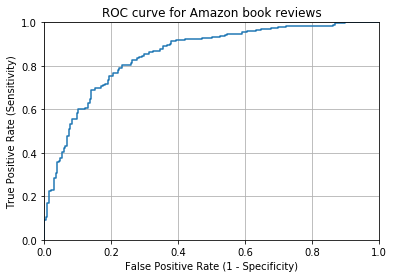

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, log_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Amazon book reviews')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [25]:
print('AUC: ', metrics.roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1]))

AUC:  0.8524828017510945


## Perform 5-fold cross validation

In [13]:
y_pred = cross_val_predict(log_model, X, y, cv=5)
print('Cross-validated predictions: ', y_pred)

Cross-validated predictions:  [0 0 0 ... 1 1 1]


In [14]:
y_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
print('Cross-validated accuracy scores: ', y_scores)
print('Mean cross-validated accuracy scores: ', y_scores.mean())

y_scores_auc = cross_val_score(log_model, X, y, cv=5, scoring='roc_auc')
print('Cross-validated auc scores: ', y_scores_auc)
print('Mean cross-validated auc scores: ', y_scores_auc.mean())

Cross-validated accuracy scores:  [0.79   0.8075 0.7675 0.7625 0.775 ]
Mean cross-validated accuracy scores:  0.7805000000000001
Cross-validated auc scores:  [0.851225 0.868    0.835775 0.83455  0.841475]
Mean cross-validated auc scores:  0.8462050000000001


### Task 3: Build a logistic regression model using TFIDF (25 points)

Transform the training data into a TFIDF matirx, and use it to build a new logistic regression model. Again, perform a 5-fold cross-validation, and compute the mean AUC.

Hint: Similar to CountVectorizer, sklearn's TfidfVectorizer function can do all the transformation work for you. Don't forget using the stop_words option.

### The words are already cleaned and stop words removed from the reviews variable

In [17]:
tfidf_transformer = TfidfTransformer()
reviews_tfidf = tfidf_transformer.fit_transform(reviews)
print(reviews_tfidf.shape)

(2000, 30903)


/Users/kandarp/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [26]:
X_idf = reviews_tfidf.toarray()
X_train, X_test, y_train, y_test = train_test_split(X_idf, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1600, 30903) (1600,)
(400, 30903) (400,)


In [27]:
log_model_idf = LogisticRegression()
log_model_idf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
predictions = log_model.predict(X_test)
print('Score: ', log_model_idf.score(X_test, y_test))

Score:  0.8


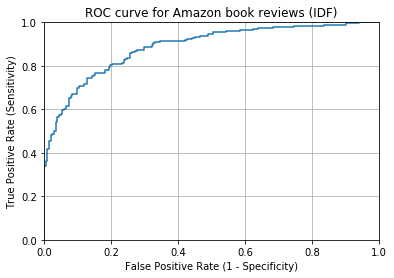

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, log_model_idf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Amazon book reviews (IDF)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [31]:
print('AUC: ', metrics.roc_auc_score(y_test, log_model_idf.predict_proba(X_test)[:,1]))

AUC:  0.8878137813781377


In [32]:
y_scores_idf = cross_val_score(log_model_idf, X_idf, y, cv=5, scoring='accuracy')
print('Cross-validated accuracy scores: ', y_scores_idf)
print('Mean cross-validated accuracy scores: ', y_scores_idf.mean())

y_scores_idf_auc = cross_val_score(log_model_idf, X_idf, y, cv=5, scoring='roc_auc')
print('Cross-validated auc scores: ', y_scores_idf_auc)
print('Mean cross-validated auc scores: ', y_scores_idf_auc.mean())

Cross-validated accuracy scores:  [0.7825 0.795  0.795  0.7675 0.7775]
Mean cross-validated accuracy scores:  0.7835
Cross-validated auc scores:  [0.867525 0.880325 0.88045  0.8523   0.872025]
Mean cross-validated auc scores:  0.870525


### Task 4: Build a logistic regression model using TFIDF over n-grams (25 points)

We still want to use the TFIDF matirx, but instead of using TFIDF over single tokens, this time we want to go further and use TFIDF values of both 1-gram and 2-gram tokens. Then use this new TFIDF matrix to build another logistic regression model. Again, perform a 5-fold cross-validation, and compute the mean AUC.

Hint: You can configure the n-gram range using an option of the TfidfVectorizer function